In [3]:
using gmsh
using LinearAlgebra
using Plots
using LaTeXStrings
using SparseArrays
using BenchmarkTools 

# Create Mesh

In [66]:
xmin = 0;
xmax = 10e-3;

a = 5e-3;

lc1 = 1e-4;
lc2 = 1e-6;

eps0  = 8.85e-12;
epsr1 = 6;
epsr2 = 2;
cfun(x) = eps0 + (epsr1 - 1) * eps0 * (x > xmin) * (x < a) + (epsr2 - 1) * eps0 * (x > a) * (x < xmax);

In [67]:
gmsh.initialize()

gmsh.model.geo.addPoint(xmin, 0, 0, lc1, 1)
gmsh.model.geo.addPoint(a, 0, 0, lc2, 2)
gmsh.model.geo.addPoint(xmax, 0, 0, lc1, 3)

gmsh.model.geo.addLine(1, 2, 1)
gmsh.model.geo.addLine(2, 3, 2)

gmsh.model.geo.synchronize()

gmsh.model.mesh.generate(1)

Error   : GEO point with tag 1 already exists


LoadError: GEO point with tag 1 already exists

In [68]:
node_ids, node_coord, _ = gmsh.model.mesh.getNodes()
xnode = node_coord[1:3:end];
p = sortperm(xnode);
x = xnode[p];
nids = node_ids[p];

gmsh.finalize()

# FEM

In [69]:
function get_idx(node_id, nids)
    return findall(x -> x == node_id, nids)[1];
end

function bnd_dirichlet(idx, a, A, f)
    A[idx,:]   = zeros(length(f));
    A[idx,idx] = 1;
    f[idx] = a;
    
    return A, f;
end

bnd_dirichlet (generic function with 1 method)

In [70]:
#..Mesh with points and edges 
#..point holds the coordinates of the left and right node of the element
#..edges holds the global indices of the left and right node of the element
points = collect( [x[i], x[i+1]] for i in 1:length(x)-1) 
edges = collect( [i, i+1] for i in 1:length(x)-1); 

#..Set the source function 
fsource(x) = 0; 

#..Initialize global matrix and right-hand side value 
A = zeros(length(x), length(x)); 
f = zeros(length(x)); 

#..Perform loop over elements and assemble global matrix and vector 
for i=1:length(edges) 
    xl, xr = points[i,:][1]
    floc = (xr-xl) / 2 * [fsource(xl); fsource(xr)];
    Aloc = (cfun(xr)+cfun(xl)) / (2*(xr-xl)) * [1 -1; -1 1]; 

    f[edges[i]] += floc;
    A[edges[i], edges[i]] += Aloc;
end

#..handle the boundary conditions in the matrix and right-hand side vector 
A, f = bnd_dirichlet(get_idx(1, nids), 1, A, f);    # Boundary at x = 0: V = 1
A, f = bnd_dirichlet(get_idx(3, nids), 0, A, f);    # Boundary at x = 1: V = 0

#..solve the linear system
u = A \ f; 

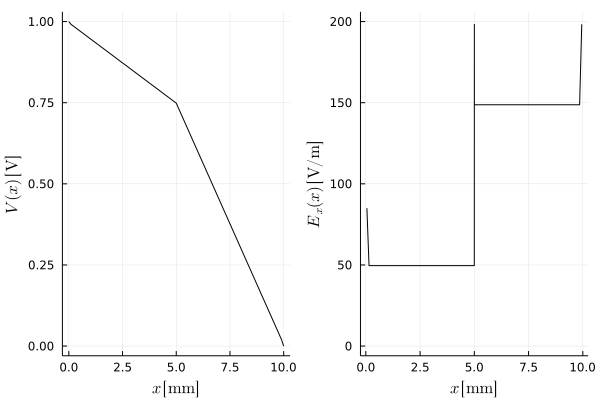

In [72]:
# Post-processing
xmid = diff(x) / 2 + x[1:end-1];
ux = -diff(u) ./ diff(x);

# Plot
p1 = plot(x * 1e3, u, xlabel = L"x\,[\mathrm{mm}]", ylabel = L"V(x)\,[\mathrm{V}]", color = :black, lw = 1, legend = false);
p2 = plot(xmid * 1e3, ux, xlabel = L"x\,[\mathrm{mm}]", ylabel = L"E_x(x)\,[\mathrm{V/m}]", ylim = [0, 200], color = :black, lw = 1, legend = false);

plot(p1, p2)

In [59]:
gmsh.fltk.run()

-------------------------------------------------------
Version       : 4.9.4
License       : GNU General Public License
Build OS      : Windows64-sdk
Build date    : 20220203
Build host    : gmsh.info
Build options : 64Bit ALGLIB[contrib] ANN[contrib] Bamg Blas[petsc] Blossom Cgns DIntegration DomHex Eigen[contrib] Fltk Gmm[contrib] Hxt Jpeg Kbipack Lapack[petsc] MathEx[contrib] Med Mesh Metis[contrib] Mmg Mpeg Netgen NoSocklenT ONELAB ONELABMetamodel OpenCASCADE OpenCASCADE-CAF OpenGL OpenMP OptHom PETSc Parser Plugins Png Post QuadMeshingTools QuadTri Solver TetGen/BR Voro++[contrib] WinslowUntangler Zlib
FLTK version  : 1.4.0
PETSc version : 3.15.0 (real arithmtic)
OCC version   : 7.6.0
MED version   : 4.1.0
Packaged by   : nt authority system
Web site      : https://gmsh.info
Issue tracker : https://gitlab.onelab.info/gmsh/gmsh/issues
-------------------------------------------------------
